In [1]:
import torch
from torchvision import datasets, transforms

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor()
                  ])),
    batch_size=1)

In [6]:
image, label = next(iter(train_loader))

In [7]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

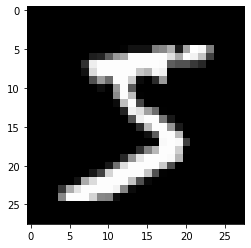

In [11]:
plt.imshow(image.squeeze(),'gray')

## Layer별 설명

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Convolution
- in_channels : 받게 될 channel의 갯수
- out_channels : 보내고 싶은 channels의 갯수
- kernel_size : 만들고 싶은 kernel(weights)의 사이즈

In [13]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [14]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [16]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [18]:
weight = weight.detach().numpy()
weight

array([[[[-2.29615718e-02, -2.46254951e-02,  7.73974210e-02,
          -1.74399853e-01, -8.74939710e-02],
         [-1.90787539e-01, -1.31208748e-01, -1.74537346e-01,
          -9.54869539e-02,  9.74870175e-02],
         [ 5.93727976e-02, -1.87487900e-02,  8.13005120e-02,
          -1.22359775e-01, -1.06964707e-01],
         [-1.21227220e-01,  1.81291744e-01,  8.45657438e-02,
           1.48926631e-01, -1.27959445e-01],
         [-3.01838219e-02,  1.13115475e-01,  3.19240391e-02,
          -7.19259232e-02, -2.14219391e-02]]],


       [[[ 8.89060050e-02,  1.76546320e-01, -1.56152651e-01,
          -1.81094557e-01,  2.61843950e-02],
         [ 5.47403842e-02, -5.60591966e-02,  1.30766317e-01,
           1.89436600e-01, -1.05289221e-01],
         [ 1.18444845e-01,  2.05564201e-02, -1.13831811e-01,
          -1.63357303e-01,  1.59688890e-02],
         [-1.12004280e-01,  8.52005035e-02, -3.97689044e-02,
           7.42359459e-03, -1.38905406e-01],
         [-1.98792890e-01, -1.90400630e-01

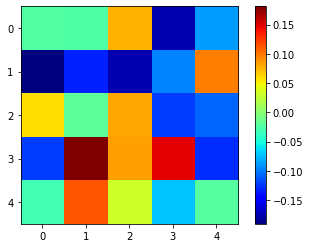

In [20]:
plt.imshow(weight[0,0,:,:], 'jet')
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [21]:
output_data = layer(image)

In [23]:
output_data = output_data.data

In [24]:
output = output_data.cpu().numpy()

In [26]:
output.shape

(1, 20, 24, 24)

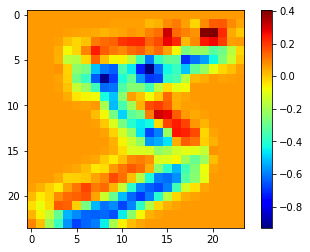

In [27]:
plt.imshow(output[0,0,:,:], 'jet')
plt.colorbar()
plt.show()

- input으로 들어간 이미지 numpy화

In [28]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

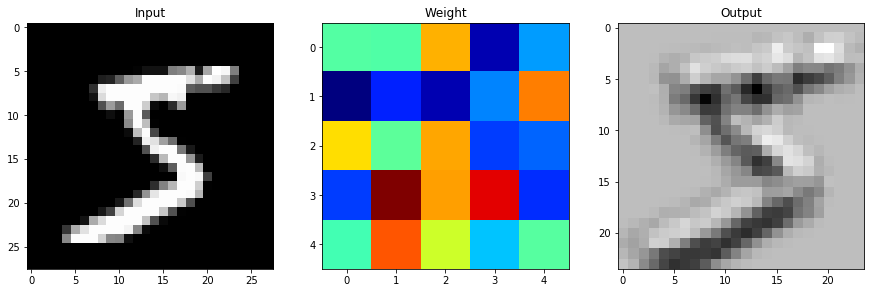

In [29]:
plt.figure(figsize=(15, 30))
plt.subplot(131)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0, 0, :, :], 'jet')
plt.subplot(133)
plt.title('Output')
plt.imshow(output[0,0,:,:], 'gray')
plt.show()

## Pooling
input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [30]:
image.shape

torch.Size([1, 1, 28, 28])

In [31]:
pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 Weight가 없기 때문에 바로 numpy()가 가능

In [32]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [33]:
image_arr.shape

(1, 1, 28, 28)

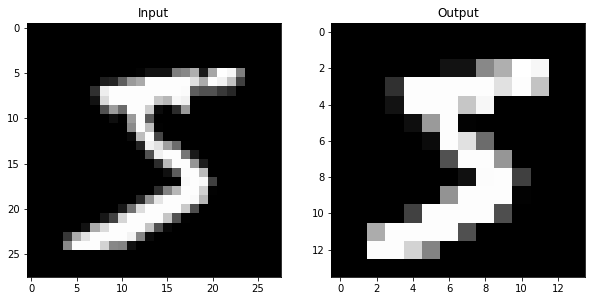

In [36]:
plt.figure(figsize=(10, 15))
plt.subplot(121)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(122)
plt.title('Output')
plt.imshow(np.squeeze(pool_arr), 'gray')
plt.show()

## Linear
nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [37]:
flatten = image.view(1, -1)
flatten.shape

torch.Size([1, 784])

In [38]:
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [39]:
lin

tensor([[ 4.3836e-01, -1.3462e-01, -4.6494e-02, -1.5985e-02,  1.1914e-04,
          4.5953e-03, -3.9513e-01, -1.4143e-01, -9.4248e-02,  1.2934e-01]],
       grad_fn=<AddmmBackward>)

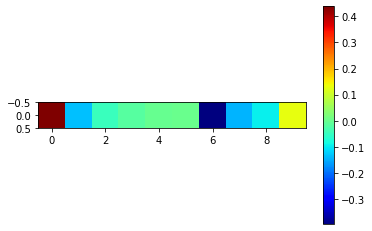

In [41]:
plt.imshow(lin.detach().numpy(),'jet')
plt.colorbar()
plt.show()

## Softmax
결과를 numpy로 꺼내기 위해선 weight가 갇ㅁ긴 Linear에 weight를 꺼줘야함

In [42]:
with torch.no_grad():
    flatten = image.view(1, 28 * 28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim=1)

In [43]:
softmax

tensor([[0.0692, 0.1153, 0.0830, 0.0672, 0.1004, 0.0913, 0.1534, 0.1180, 0.0969,
         0.1054]])

In [44]:
np.sum(softmax.numpy())

1.0

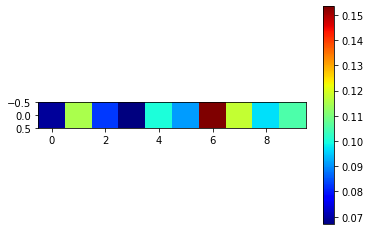

In [45]:
plt.imshow(softmax.detach().numpy(),'jet')
plt.colorbar()
plt.show()